# Creation of index with percentage of stocks above the 50-day exponential moving average

In this notebook we present a basic method to calculate the percentage of a stock index constituents whose prices are above the 50 day exponential moving average (50EMA).

The output is similar to the [MMTH](https://www.tradingview.com/symbols/INDEX-MMTH/) or the [NDXA50R](https://stockcharts.com/freecharts/gallery.html?$ndxa50r).

<img src='https://i.imgur.com/0xBvCMX.png'>

(image source: [macrovar.com](https://macrovar.com/united-states/nasdaq-100-percent-of-stocks-above-50-day-ma-ndxa50r/))

Process overview:

1.   Download stock price data for the desired period from YAHOO! Finance.
2.   Calculate the 50-day EMA for each day and each ticker. 
3.   Generate the chart.

For this example we work with the [Athex Composite Share Price index](https://www.athexgroup.gr/index-profile/-/select-index/17) (BBG ASE:IND).

The code can be reused to estimate an "index" using other index constituents or even a custom basket of securities.


## Install / import libraries

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns

## Generate dataset
A list of the current constituents of the ATHEX Composite Index can be found [here](https://www.athexgroup.gr/web/guest/index-composition/-/select-index/17).

In [3]:
# list of ticker names composing the Athens Stock Exchange General Index (BBG: ASE:IND). The keys are the greek symbols and the values are the corresponding symbols in YAHOO! Finance.
atgStonks = {'ΑΛΦΑ':'ALPHA.AT',
             'ΕΤΕ':'ETE.AT',
             'ΕΥΡΩΒ':'EUROB.AT',
             'ΠΕΙΡ':'TPEIR.AT',
             'ΑΛΜΥ':'ALMY.AT',
             'ΕΛΣΤΡ':'ELSTR.AT',
             'ΕΛΧΑ':'ELHA.AT',
             'TITC':'TITC.AT',
             'ΑΒΑΞ':'AVAX.AT',
             'ΓΕΚΤΕΡΝΑ':'GEKTERNA.AT',
             'ΕΛΛΑΚΤΩΡ':'ELLAKTOR.AT',
             'ΙΚΤΙΝ':'IKTIN.AT',
             'ΙΝΚΑΤ':'INKAT.AT',
             'ΜΠΕΛΑ':'BELA.AT',
             'ΟΛΥΜΠ':'OLYMP.AT',
             'ΟΤΟΕΛ':'OTOEL.AT',
             'ΕΛΠΕ':'ELPE.AT',
             'ΜΟΗ':'MOH.AT',
             'ΕΧΑΕ':'EXAE.AT',
             'ΜΙΓ':'MIG.AT',
             'ΕΕΕ':'EEE.AT',
             'ΚΡΙ':'KRI.AT',
             'ΙΑΤΡ':'IATR.AT',
             'CENER':'CENER.AT',
             'ΒΙΟ':'VIO.AT',
             'ΕΛΤΟΝ':'ELTON.AT',
             'ΜΥΤΙΛ':'MYTIL.AT',
             'ΟΛΘ':'OLTH.AT',
             'ΟΛΠ':'PPA.AT',
             'ΠΕΤΡΟ':'PETRO.AT',
             'ΠΛΑΘ':'PLAT.AT',
             'ΠΛΑΚΡ':'PLAKR.AT',
             'ΕΥΠΙΚ':'EUPIC.AT',
             'ΙΝΛΙΦ':'INLIF.AT',
             'ΠΑΠ':'PAP.AT',
             'ΣΑΡ':'SAR.AT',
             'ΚΑΜΠ':'KAMP.AT',
             'ΚΕΚΡ':'KEKR.AT',
             'ΛΑΜΔΑ':'LAMDA.AT',
             'ΜΠΡΙΚ':'BRIQ.AT',
             'ΠΡΕΜΙΑ':'PREMIA.AT',
             'ΜΟΤΟ':'MOTO.AT',
             'ΠΛΑΙΣ':'PLAIS.AT',
             'ΦΡΛΚ':'FOYRK.AT',
             'ΒΥΤΕ':'BYTE.AT',
             'ΕΝΤΕΡ':'ENTER.AT',
             'ΕΠΣΙΛ':'EPSIL.AT',
             'ΙΝΤΕΚ':'INTEK.AT',
             'ΚΟΥΕΣ':'QUEST.AT',
             'ΠΡΟΦ':'PROF.AT',
             'ΙΝΤΚΑ':'INTRK.AT',
             'ΟΤΕ':'HTO.AT',
             'ΣΠΕΙΣ':'SPACE.AT',
             'ΑΡΑΙΓ':'AEGN.AT',
             'ΟΠΑΠ':'OPAP.AT',
             'ΑΔΜΗΕ':'ADMIE.AT',
             'ΔΕΗ':'PPC.AT',
             'ΕΥΑΠΣ':'EYAPS.AT',
             'ΕΥΔΑΠ':'EYDAP.AT',
             'ΤΕΝΕΡΓ':'TENERGY.AT'}

In [4]:
# we are interested only in the closing price, we fetch the last three years worth of data (practially right before the COVID crash).
tickers = yf.Tickers(list(atgStonks.values()))
data = tickers.download(period='3y',interval='1d', actions=True,auto_adjust=True)['Close']

[*********************100%***********************]  60 of 60 completed


In [5]:
# have a look at a sample of the stocks
data.tail(5)

,ADMIE.AT,AEGN.AT,ALMY.AT,ALPHA.AT,AVAX.AT,BELA.AT,BRIQ.AT,BYTE.AT,CENER.AT,EEE.AT,...,PPC.AT,PREMIA.AT,PROF.AT,QUEST.AT,SAR.AT,SPACE.AT,TENERGY.AT,TITC.AT,TPEIR.AT,VIO.AT
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-20,1.780,4.875,1.920,0.9150,0.789,14.60,1.86,3.170,2.840,21.74,...,5.240,1.180,2.945,4.215,6.00,7.26,16.700001,11.10,1.1810,3.485
2022-09-21,1.762,4.790,1.896,0.8810,0.779,14.57,1.86,3.280,2.820,21.91,...,5.220,1.185,2.930,4.220,5.84,7.22,16.629999,11.18,1.1550,3.390
2022-09-22,1.748,4.750,1.894,0.8802,0.776,14.03,1.87,3.495,2.800,21.82,...,5.175,1.180,2.970,4.240,5.86,7.06,16.350000,10.96,1.1495,3.400
2022-09-23,1.718,4.600,1.860,0.8500,0.771,13.60,1.86,3.495,2.735,21.43,...,5.150,1.155,2.900,4.185,5.86,7.04,15.850000,10.84,1.0900,3.350
2022-09-26,1.690,4.675,1.834,0.8470,0.811,13.50,1.85,3.495,2.695,21.85,...,5.280,1.145,2.800,4.050,5.80,6.84,15.440000,10.76,1.1055,3.405


## Process dataset

In [6]:
# stack to multi index
t = data.stack()

# rename 'value' column
t.name = 'Close'

# save series to data frame
t = t.to_frame()

# calculate ema 50
t2 = t.groupby(level=1).apply(lambda x: x.ewm(span=50).mean())

# merge dataframes
t3 = pd.merge(t, t2, left_index=True, right_index=True)

# unstack
t4 = t3.reset_index(level=[0,1])

# create bool column to store whether price is above ema50
comparison_column = np.where(t4["Close_y"] < t4["Close_x"], True, False)
t4["above"] = comparison_column

# delete "Close_y" and "Close_X" prices as we don't need them - they store the actual close price and the EMA50 price
del t4["Close_x"]
del t4["Close_y"]

# group by date
t4 = t4.groupby('Date')['above'].mean()*100

# save series to data frame
t4 = t4.to_frame()

# keep data from 01/01/2020 and beyond
t4 = t4[t4.index > '2020-01-01']

# look at a sample of the result
t4.tail(10)

,above
Date,
2022-09-13,38.333333
2022-09-14,41.666667
2022-09-15,40.000000
2022-09-16,35.000000
2022-09-19,31.666667
2022-09-20,35.000000
2022-09-21,23.333333
2022-09-22,21.666667
2022-09-23,18.333333


In [ ]:
# optionally export to xls
t4.to_excel('stocksAbove50EMA.xlsx')

## Plot index

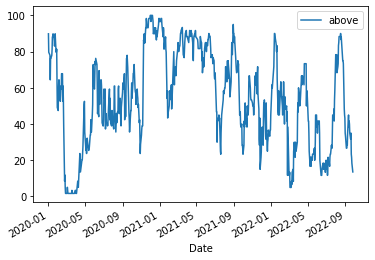

In [7]:
# basic plot of our index
t4.plot()

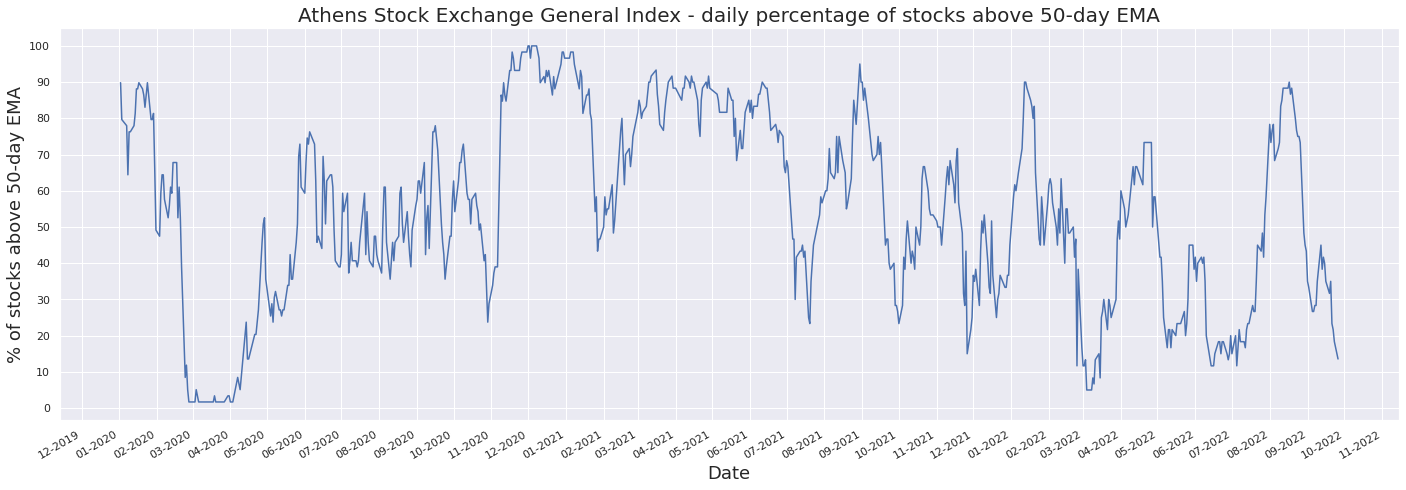

In [36]:
# ...or a bit nicer plot with seaborn
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 8))
fig = sns.lineplot(data=t4, legend = False)
fig.set_title("Athens Stock Exchange General Index - daily percentage of stocks above 50-day EMA", fontsize = 20)
fig.set_ylabel('% of stocks above 50-day EMA', fontsize = 18)
fig.set_xlabel('Date', fontsize = 18)
ax.set_yticks(np.arange(0, 101, 10))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.gcf().autofmt_xdate()